# Performance analysis experiments

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

## 1. Load vs. compute time breakdown

Change directory to `experiments/`. Run the `perf.py` script with different arguments for different experiment parameters. Use the `-b` option so that the mock client blocks on each request.

```sh
python perf.py [-b] [-m MODEL_NAME] [-n NUM_MODELS] [-t TP_WORLD_SIZE] [-p PP_WORLD_SIZE] [-r NUM_REQUESTS]
```

Then run the cells below with `debug = False` to extract time data from logs.

For reference, Perlmutter GPU nodes have 4x A100 40GB GPUs per mode, each with a PCIe 4.0 x16 CPU-GPU link that has 32 GB/s bandwidth.

### 1.1. Scaling number of GPUs

In [2]:
log_dir = "perf_logs"
debug = True

if debug:
    # Experiment parameters to debug this notebook
    model_name = "opt-1.3b"
    parallel_configs = [(1, 1), (2, 1), (2, 1), (1, 2), (1, 2), (1, 1)]
else:
    # True experiment parameters
    model_name = "opt-13b"
    parallel_configs = [(1, 1), (2, 1), (4, 1), (1, 2), (1, 4), (2, 2)]

In [3]:
def round_robin_times(tp=1, pp=1):
    load_times = []
    model_times = []
    resp_times = []
    with open(f'{log_dir}/round_robin_{model_name}_{tp}_{pp}.log', 'r') as file:
        for line in file:
            if 'load time' in line:
                t = re.search(r'load time: (\d+\.\d+)', line).group(1)
                load_times.append(float(t))
            if 'model time' in line:
                t = re.search(r'model time: (\d+\.\d+)', line).group(1)
                model_times.append(float(t))
            elif 'response time' in line:
                t = re.search(r'response time: (\d+\.\d+)', line).group(1)
                resp_times.append(float(t))

    # Remove first 4 warm up requests
    return (
        load_times[4:], 
        model_times[4:],
        resp_times[4:],
    )

[[0.38126628 0.28672971 0.66932743]
 [0.23109684 0.18930521 0.42181045]
 [0.23109684 0.18930521 0.42181045]
 [0.39515692 0.26577698 0.66239464]
 [0.39515692 0.26577698 0.66239464]
 [0.38126628 0.28672971 0.66932743]]


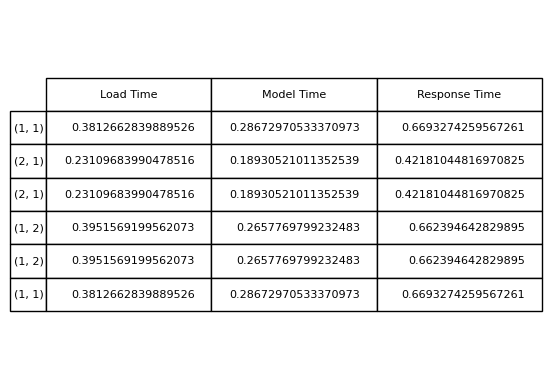

In [4]:
times = []
for pc in parallel_configs:
    times.append(round_robin_times(*pc))

times = np.array(times) # (parallel_config, timer, request)
mean_times = np.mean(times, axis=2)
print(mean_times)

rows = [str(p) for p in parallel_configs]
cols = ["Load Time", "Model Time", "Response Time"]
plt.axis("off")
plt.axis("tight")
tab = plt.table(mean_times, rowLabels=rows, colLabels=cols, loc="center")
tab.scale(1, 2)
plt.show()

#### 1.1.1. Scaling TP

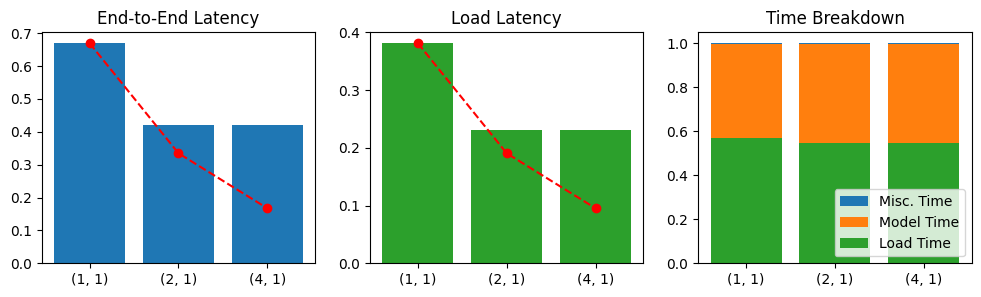

In [18]:
x = ["(1, 1)", "(2, 1)", "(4, 1)"]
mean_tp = mean_times[[0, 1, 2], :]
mean_resp = mean_tp[:, 2]

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].bar(x, mean_resp)
axs[0].plot(x, [mean_resp[0] / i for i in [1, 2, 4]], color="red", marker="o", linestyle="--")
axs[0].set_title("End-to-End Latency")

axs[1].bar(x, mean_tp[:, 0], color="#2ca02c")
axs[1].plot(x, [mean_tp[0, 0] / i for i in [1, 2, 4]], color="red", marker="o", linestyle="--")
axs[1].set_title("Load Latency")

axs[2].bar(x, 1, label="Misc. Time")
axs[2].bar(x, np.sum(mean_tp[:, :2], axis=1) / mean_resp, label="Model Time")
axs[2].bar(x, mean_tp[:, 0] / mean_resp, label="Load Time")
axs[2].set_title("Time Breakdown")
axs[2].legend(loc="lower right")

plt.show()

#### 1.1.2. Scaling PP

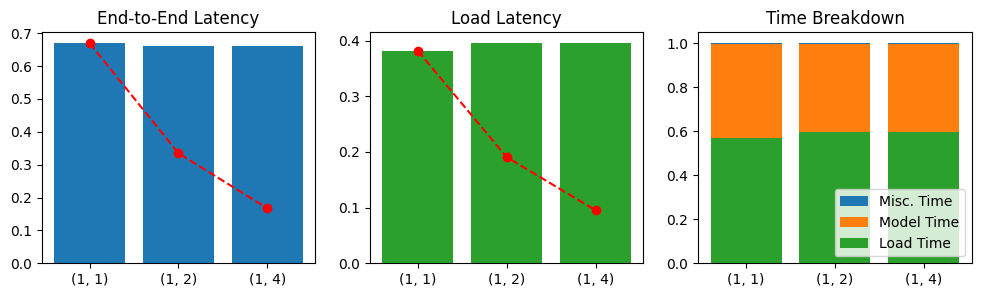

In [19]:
x = ["(1, 1)", "(1, 2)", "(1, 4)"]
mean_pp = mean_times[[0, 3, 4], :]
mean_resp = mean_pp[:, 2]

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].bar(x, mean_resp)
axs[0].plot(x, [mean_resp[0] / i for i in [1, 2, 4]], color="red", marker="o", linestyle="--")
axs[0].set_title("End-to-End Latency")

axs[1].bar(x, mean_pp[:, 0], color="#2ca02c")
axs[1].plot(x, [mean_pp[0, 0] / i for i in [1, 2, 4]], color="red", marker="o", linestyle="--")
axs[1].set_title("Load Latency")

axs[2].bar(x, 1, label="Misc. Time")
axs[2].bar(x, np.sum(mean_pp[:, :2], axis=1) / mean_resp, label="Model Time")
axs[2].bar(x, mean_pp[:, 0] / mean_resp, label="Load Time")
axs[2].set_title("Time Breakdown")
axs[2].legend(loc="lower right")

plt.show()